In [9]:
import numpy as np
import pandas as pd
import pyodbc
from configparser import ConfigParser

In [72]:
reload=False # set to true to reload from DB

In [70]:
if reload:
    parser = ConfigParser()
    parser.read('params.cfg')
    conn = pyodbc.connect(f"""DRIVER={{MySQL ODBC 8.0 Unicode Driver}};
                              SERVER={parser.get('DB_PARAMS', "DB_URL")};
                              DATABASE={parser.get('DB_PARAMS', "DB_DB")};
                              USER={parser.get('DB_PARAMS', "DB_USER")};
                              PASSWORD={parser.get('DB_PARAMS', "DB_PASS")};
                            OPTION=3;""")

In [71]:
if reload:
    filer_df = pd.read_sql("select * from Filer",conn)
    display(filer_df.head())

,Id,CIK,ManagerName,Street1,Street2,City,StateOrCountry,ZipCode
0,1,0000002230,ADAMS EXPRESS CO,7 ST PAUL STREET,SUITE 1140,BALTIMORE,MD,21202
1,2,0000007195,"ARGUS INVESTORS' COUNSEL, INC.",HOLLY POND PLAZA,"1281 E. MAIN STREET, FIRST FLOOR",STAMFORD,CT,06902
2,3,0000009015,BABSON CAPITAL MANAGEMENT LLC,470 ATLANTIC AVENUE,10TH FLOOR,BOSTON,MA,02210
3,4,0000009631,BANK OF NOVA SCOTIA /,44 KING STREET WEST,SCOTIA PLAZA 8TH FL.,TORONTO,A6,M5H 1H1
4,5,0000009634,"BOKF, NA",PO BOX 2300,,TULSA,OK,74172


In [13]:
if reload:
    filing_df = pd.read_sql("select *, concat(YEAR(Filing.SignatureDate), '-', QUARTER( Filing.SignatureDate )) as Period from Filing", conn)
    filing_df = filing_df.sort_values('SignatureDate').drop_duplicates(subset=['FilerId', 'Period'], keep='last').sort_values(['FilerId', 'Period']).reset_index(drop=True)
    display(filing_df.head())

In [14]:
if reload:
    security_df = pd.read_sql("select * from Security", conn)
    display(security_df.head())

In [15]:
if reload:
    holding_df = pd.read_sql("select * from Holding", conn)
    display(holding_df.head())

In [16]:
filer_df[filer_df['Id']==964]

,Id,CIK,ManagerName,Street1,Street2,City,StateOrCountry,ZipCode
963,964,0001013234,ORLEANS CAPITAL MANAGEMENT CORP/LA,830 WEST CAUSEWAY APPROACH,SUITE 1200,MANDEVILLE,LA,70471


# Goal

I want to analyze aspects of different funds, essentially do an unsupervised clustering algorithm to see if there are pockets of funds that outperform and if there are key attributes to a fund that make it likley to outperform.

This is mostly done with feature engineering, there is a lot of raw data, but how to pull out features that matter.

* Should each filing be considered it's own entry?  If so, then we have less time-series and more point-in-time clustering
* If each Filer is it's own entry, do we aggregate transition statistics?
* How do we handle Filers who only have partial filings?  Does it matter?

Features

* Number of holdings (normalized)
* Number of holdings making up 50% (normalized)
* Number of holdings making up 10% (normalized)
* Active Share Score (need to see if we can calculate this)
* Percent Turnover (Not sure how to calculate this yet, want to remove in-flows and track actual selling/buying activity)

Lets start by looking at a single Filer and build out the time series for them to see what needs done

In [17]:
# lets get all of berkshire's filings
if reload:
    filing_df[filing_df['FilerId']==867]

In [18]:
if reload:
    grouped_holdings = holding_df.drop('Id', axis=1).groupby(['FilingId', 'SecurityId']).sum()
    grouped_holdings['PercentValue'] = grouped_holdings.groupby(level=0)['ValueOfShares'].apply(lambda x:100 * x / float(x.sum()))
    grouped_holdings = grouped_holdings.reset_index()
    grouped_holdings['SharePrice'] = grouped_holdings['ValueOfShares'] / grouped_holdings['NumberOfShares']
    grouped_holdings = grouped_holdings.merge(security_df, left_on='SecurityId', right_on='Id', suffixes=('','_sec')) \
        .merge(filing_df, left_on='FilingId', right_on='Id', suffixes=('', '_fil')) \
        [['Id', 'FilerId', 'FilingId','SecurityId', 'CUSIP', 'Name', 'ValueOfShares', 'NumberOfShares','SharePrice','PercentValue', 'Period']]
    grouped_holdings.to_csv('./grouped_holdings.csv', index=False)

In [19]:
if not reload:
    grouped_holdings = pd.read_csv('./grouped_holdings.csv')

In [20]:
# each row is an entry and needs to have the features calculated for it based on the holdings for each period
# NOTE: need to group by Security ID and sum ValueOfShares since some Securities have multiple entries due to different bases
holdings = grouped_holdings[grouped_holdings['FilingId']==877].sort_values('PercentValue', ascending=False)
num_holdings = holdings.shape[0]
value_of_holdings = holdings['ValueOfShares'].sum()
num_holdings_10_prct = np.sum(holdings.sort_values('PercentValue', ascending=False)['ValueOfShares'].cumsum()<=(value_of_holdings*0.10))
num_holdings_20_prct = np.sum(holdings.sort_values('PercentValue', ascending=False)['ValueOfShares'].cumsum()<=(value_of_holdings*0.20))
num_holdings_50_prct = np.sum(holdings.sort_values('PercentValue', ascending=False)['ValueOfShares'].cumsum()<=(value_of_holdings*0.50))

In [21]:
value_of_holdings

104836593000

In [22]:
num_holdings_10_prct

0

In [23]:
num_holdings_20_prct

0

In [24]:
num_holdings_50_prct

3

In [25]:
holdings['ValueOfShares'].sum()

104836593000

In [26]:
21040998000/104836593000

0.2007028023125475

In [27]:
holdings.sort_values('PercentValue', ascending=False)

,Id,FilerId,FilingId,SecurityId,CUSIP,Name,ValueOfShares,NumberOfShares,SharePrice,PercentValue,Period
26169846,84,867,877,84,949746101,WELLS FARGO & CO. NEW,21040998000,463458123,45.399998,20.070280,2014-1
26169839,24,867,877,24,191216100,COCA-COLA CO.,16524000000,400000000,41.310000,15.761672,2014-1
26169847,90,867,877,90,025816109,American Express Co,13755639000,151610700,90.730001,13.121028,2014-1
26169842,47,867,877,47,459200101,INTERNATIONAL BUSINESS MACHINES,12777641000,68121984,187.570007,12.188150,2014-1
26169844,70,867,877,70,742718109,PROCTER & GAMBLE CO.,4297885000,52793078,81.410010,4.099604,2014-1
26169840,37,867,877,37,30231G102,EXXON MOBIL CORP.,4162320000,41129643,101.200003,3.970293,2014-1
26169851,111,867,877,111,931142103,Wal-Mart Stores Inc,3893875000,49483733,78.690001,3.714233,2014-1
26169850,109,867,877,109,902973304,US Bancorp DE,3204565000,79320901,40.400008,3.056724,2014-1
26169856,326,867,877,326,25490A309,DIRECTV,2521705000,36514700,69.059995,2.405367,2014-1
26169854,311,867,877,311,23918K108,DAVITA HEALTHCARE PARTNERS INC.,2310552000,36461294,63.369994,2.203956,2014-1


In [28]:
# lets see what a series of a single security looks like for this Filer
grouped_holdings[
    (grouped_holdings['FilerId']==867) &
    (grouped_holdings['SecurityId']==47)
].sort_values('PercentValue')

,Id,FilerId,FilingId,SecurityId,CUSIP,Name,ValueOfShares,NumberOfShares,SharePrice,PercentValue,Period
24199871,47,867,67286,47,459200101,INTERNATIONAL BUSINESS MACHINES,314211000,2048045,153.419969,0.164300,2018-1
24074731,47,867,62917,47,459200101,INTERNATIONAL BUSINESS MACHINES,5371833000,37026698,145.079991,3.023340,2017-4
23943457,47,867,58515,47,459200101,INTERNATIONAL BUSINESS MACHINES,8319845000,54084673,153.829995,5.131156,2017-3
23814502,47,867,54081,47,459200101,INTERNATIONAL BUSINESS MACHINES,11242819000,64561955,174.140002,6.945421,2017-2
25912328,47,867,32697,47,459200101,INTERNATIONAL BUSINESS MACHINES,11151823000,81033450,137.619995,8.457607,2016-1
23689176,47,867,49679,47,459200101,INTERNATIONAL BUSINESS MACHINES,13483751000,81232303,165.990013,9.111554,2017-1
25896355,47,867,28505,47,459200101,INTERNATIONAL BUSINESS MACHINES,11747419000,81033450,144.969997,9.220347,2015-4
23450268,47,867,41156,47,459200101,INTERNATIONAL BUSINESS MACHINES,12329439000,81232303,151.780001,9.505774,2016-3
23337803,47,867,36906,47,459200101,INTERNATIONAL BUSINESS MACHINES,12302631000,81232303,151.449984,9.568846,2016-2
23565858,47,867,45427,47,459200101,INTERNATIONAL BUSINESS MACHINES,12903752000,81232303,158.850008,10.019444,2016-4


so, we want to calculate `turn over` of this portfolio.  Normally you'd remove any known in or out flows because
what we care about mostly is the desired allocation of the fund as a whole

If we calculated it as a change in value of shares, then a share that did well would look like a it increased in allocation

Take 2 securities, A, B.  A is worth $50 and B is worth $100.  A Portfolio is made up of equal parts of each.  Say 2 shares of A and 1 Share of B

* A: 2 @ $ 50 = $100 total: 66.6% by NumberOfShares and 50% by ValueOfShares
* B: 1 @ $100 = $100 total: 33.3% by NumberOfShares and 50% by ValueOfShares

1st: Over the course of a month, the price of A and B both went up 50%

* A: 2 @ $ 75 = $150 total: 66.6% by NumberOfShares and 50% by ValueOfShares
* B: 1 @ $150 = $150 total: 33.3% by NumberOfShares and 50% by ValueOfShares

Nothing unexpected here.  By both measures, there was no turn over, nor would we expect there to be.

2nd: Now, assume we change allocation so that B is 2X A

* A: 2 @ $ 50 = $100 total: 50.0% by NumberOfShares and 33.3% by ValueOfShares
* B: 2 @ $100 = $200 total: 50.0% by NumberOfShares and 66.6% by ValueOfShares

As expected A's percentage of shares went down in both cases and B's went up

3rd: Now, 0 turn over, but A increases 100% in values

* A: 2 @ $100 = $200 total: 66.6% by NumberOfShares and 66.6% by ValueOfShares
* B: 1 @ $100 = $100 total: 33.3% by NumberOfShares and 33.3% by ValueOfShares

Here is a situation where the number of shares did not change, but the value did.  No turnover expected

Lets experiment with a calculation that may help describe what we are trying to capture.

(|NewNumberOfShares - OldNumberOfShares| * NewSharePrice) / NewTotalValue <- do this for each share and sum for portfolio turn over

1st case where both went up 50%

* A: |2-2| * $ 75 / $300 = 0
* B: |1-1| * $150 / $300 = 0

Good

2nd case where B went up 2X of A

* A: |2-2| * $ 75 / $300 = 0
* B: |2-1| * $100 / $300 = 0.33

We have a change as expected.

3rd case where A increased and B stayed the same will be 0 as well with no change in number of shares

4th: Another case, where we DOUBLE each holding's number of shares

* A: |4-2| * $ 50 / $400 = 0.25
* B: |2-1| * $100 / $400 = 0.25

Total of 0.5.  Now, here is a case where the ratio stayed the same, we had inflows, maintained proportioning and still showed turn-over.



Okay, lets try 
((NewNumberOfShares * NewSharePrice) / NewTotalValue) - ((OldNumberOfShares * OldSharePrice) / OldTotalValue)

1st case

* A: ((2*  75) / 300) - ((2*  50) / 200) = 0.5 - 0.5 = 0
* B: ((1* 150) / 300) - ((1* 100) / 200) = 0.5 - 0.5 = 0

Good

2nd case

* A: ((2*  50) / 300) - ((2*  50) / 200) = 0.33 - 0.5 = -0.17
* B: ((2* 100) / 300) - ((1 *100) / 200) = 0.66 - 0.5 = 0.17

Okay, this is 0, but if we abs it we get 0.33, more realistic

3rd case

* A: ((2* 100) / 300) - ((2*  50) / 200) = 0.66 - 0.5 = 0.17
* B: ((1* 100) / 300) - ((1* 100) / 200) = 0.33 - 0.5 = -0.17


None of these calculations are working, what I really want to know is how much is begin sold?  essentially %of portfolio sold in total value, even if total value is the same.

The previous have been failing because I compared change in # of shares to change in Dollars

|NewNumberOfShares/NewTotalNumShares - OldNumberOfShares/OldTotalNumShares| <- do this for each share and sum for portfolio turn over

1st case

* A: |2/3 - 2/3| = 0
* B: |1/3 - 1/3| = 0

2nd case

* A: |2/4 - 2/3| = 0.16
* B: |2/4 - 1/3| = 0.16
0.33

3rd case

* A: |2/3 - 2/3| = 0
* B: |1/3 - 1/3| = 0

In [29]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [30]:
grouped_holdings[
    (grouped_holdings['FilerId']==867)
    & (grouped_holdings['SecurityId']==11)
].sort_values('Period')

,Id,FilerId,FilingId,SecurityId,CUSIP,Name,ValueOfShares,NumberOfShares,SharePrice,PercentValue,Period
26169838,11,867,877,11,064058100,BANK OF NEW YORK MELLON CORP.,861370000,24652836,34.94000,0.82163,2014-1
26172531,11,867,4655,11,064058100,BANK OF NEW YORK MELLON CORP.,869997000,24652836,35.28994,0.82252,2014-2
26174965,11,867,8465,11,064058100,BANK OF NEW YORK MELLON CORP.,923989000,24652836,37.48003,0.85888,2014-3
26176884,11,867,12324,11,064058100,BANK OF NEW YORK MELLON CORP.,905413000,23377603,38.72993,0.84001,2014-4
26179443,11,867,16129,11,064058100,BANK OF NEW YORK MELLON CORP.,893050000,22012603,40.56994,0.81658,2015-1
26181609,11,867,20265,11,064058100,BANK OF NEW YORK MELLON CORP.,832180000,20680420,40.24000,0.77677,2015-2
26184669,11,867,24345,11,064058100,BANK OF NEW YORK MELLON CORP.,867957000,20680420,41.96999,0.80979,2015-3
25896352,11,867,28505,11,064058100,BANK OF NEW YORK MELLON CORP.,787393000,20112212,39.15000,0.61801,2015-4
25912325,11,867,32697,11,064058100,BANK OF NEW YORK MELLON CORP.,829026000,20112212,41.22003,0.62874,2016-1
23337800,11,867,36906,11,064058100,BANK OF NEW YORK MELLON CORP.,767066000,20827212,36.82999,0.59662,2016-2


In [31]:
grouped_holdings['TotalValueOfShares'] = grouped_holdings.groupby(['FilingId'])['ValueOfShares'].transform('sum')

In [32]:
grouped_holdings['TotalNumberOfShares'] = grouped_holdings.groupby(['FilingId'])['NumberOfShares'].transform('sum')

In [33]:
grouped_holdings['LastNumberOfShares'] = grouped_holdings.sort_values('Period').groupby(['FilerId', 'SecurityId'])['NumberOfShares'].shift().fillna(0).astype('int')

In [34]:
k = grouped_holdings[['Period', 'FilerId', 'NumberOfShares']].sort_values(['FilerId','Period']).groupby(['Period', 'FilerId']).sum().reset_index()
k = k.rename(columns={"NumberOfShares": "TotalNumberOfShares"})

k2 = k.set_index(["Period", "FilerId"]) # index
k2 = k2.unstack().shift(fill_value=0).fillna(0)          # pull out the groups, shift with lag step=1
k2 = k2.stack(dropna=False);        # stack the groups back, keep the missing values
k2 = k2.reset_index().sort_values("FilerId")
k2 = k2.rename(columns={"TotalNumberOfShares": "LastTotalNumberOfShares"})
k2['LastTotalNumberOfShares'] = k2['LastTotalNumberOfShares'].astype('uint')

if 'LastTotalNumberOfShares' in grouped_holdings.columns:
    grouped_holdings = grouped_holdings.drop('LastTotalNumberOfShares', axis=1)
grouped_holdings = grouped_holdings.merge(k2, left_on=['Period', 'FilerId'], right_on=['Period', 'FilerId'])

In [35]:
grouped_holdings['TurnOver'] = ((grouped_holdings['NumberOfShares']/grouped_holdings['TotalNumberOfShares']) - (grouped_holdings['LastNumberOfShares']/grouped_holdings['LastTotalNumberOfShares'])).abs().replace([np.inf, -np.inf], np.nan).fillna(0)

In [51]:
#|NewNumberOfShares/NewTotalNumShares - OldNumberOfShares/OldTotalNumShares| <- do this for each share and sum for portfolio turn over
grouped_holdings.to_csv('./grouped_holdings_v2.csv', index=False)

In [37]:
grouped_holdings[
    (grouped_holdings['FilerId']==867)
    &(grouped_holdings['SecurityId']==8)]

,Id,FilerId,FilingId,SecurityId,CUSIP,Name,ValueOfShares,NumberOfShares,SharePrice,PercentValue,Period,TotalValueOfShares,TotalNumberOfShares,LastNumberOfShares,LastTotalNumberOfShares,TurnOver
23337799,8,867,36906,8,037833100,APPLE INC.,1069382000,9811747,108.98997,0.83175,2016-2,128569639000,2117826110,0,2186987923,0.00463
23450264,8,867,41156,8,037833100,APPLE INC.,1455768000,15227702,95.59998,1.12237,2016-3,129704731000,2115799769,9811747,2117826110,0.00256
23565854,8,867,45427,8,037833100,APPLE INC.,1721492000,15227702,113.05002,1.33670,2016-4,128787110000,2090899991,15227702,2115799769,0.00009
23689172,8,867,49679,8,037833100,APPLE INC.,6643394000,57359652,115.81998,4.48923,2017-1,147985198000,2379274801,15227702,2090899991,0.01683
23814498,8,867,54081,8,037833100,APPLE INC.,18583441000,129357106,143.65999,11.48020,2017-2,161873831000,2445665381,57359652,2379274801,0.02878
23943454,8,867,58515,8,037833100,APPLE INC.,18750246000,130191960,144.02000,11.56397,2017-3,162143689000,2448229863,129357106,2445665381,0.00029
24074728,8,867,62917,8,037833100,APPLE INC.,20666379000,134092782,154.12000,11.63132,2017-4,177678767000,3113472098,130191960,2448229863,0.01011
24199868,8,867,67286,8,037833100,APPLE INC.,27979467000,165333962,169.23000,14.63035,2018-1,191242697000,3127003178,134092782,3113472098,0.00980
24336202,8,867,72016,8,037833100,APPLE INC.,40194658000,239567633,167.78000,21.27333,2018-2,188943876000,3192735277,165333962,3127003178,0.02216
24475361,8,867,76777,8,037833100,APPLE INC.,46639553000,251955877,185.11000,23.84243,2018-3,195615793000,3207700902,239567633,3192735277,0.00351


In [38]:
grouped_holdings[
    (grouped_holdings['FilerId']==867)
    &(grouped_holdings['SecurityId']==8)].sort_values('Period')

,Id,FilerId,FilingId,SecurityId,CUSIP,Name,ValueOfShares,NumberOfShares,SharePrice,PercentValue,Period,TotalValueOfShares,TotalNumberOfShares,LastNumberOfShares,LastTotalNumberOfShares,TurnOver
23337799,8,867,36906,8,037833100,APPLE INC.,1069382000,9811747,108.98997,0.83175,2016-2,128569639000,2117826110,0,2186987923,0.00463
23450264,8,867,41156,8,037833100,APPLE INC.,1455768000,15227702,95.59998,1.12237,2016-3,129704731000,2115799769,9811747,2117826110,0.00256
23565854,8,867,45427,8,037833100,APPLE INC.,1721492000,15227702,113.05002,1.33670,2016-4,128787110000,2090899991,15227702,2115799769,0.00009
23689172,8,867,49679,8,037833100,APPLE INC.,6643394000,57359652,115.81998,4.48923,2017-1,147985198000,2379274801,15227702,2090899991,0.01683
23814498,8,867,54081,8,037833100,APPLE INC.,18583441000,129357106,143.65999,11.48020,2017-2,161873831000,2445665381,57359652,2379274801,0.02878
23943454,8,867,58515,8,037833100,APPLE INC.,18750246000,130191960,144.02000,11.56397,2017-3,162143689000,2448229863,129357106,2445665381,0.00029
24074728,8,867,62917,8,037833100,APPLE INC.,20666379000,134092782,154.12000,11.63132,2017-4,177678767000,3113472098,130191960,2448229863,0.01011
24199868,8,867,67286,8,037833100,APPLE INC.,27979467000,165333962,169.23000,14.63035,2018-1,191242697000,3127003178,134092782,3113472098,0.00980
24336202,8,867,72016,8,037833100,APPLE INC.,40194658000,239567633,167.78000,21.27333,2018-2,188943876000,3192735277,165333962,3127003178,0.02216
24475361,8,867,76777,8,037833100,APPLE INC.,46639553000,251955877,185.11000,23.84243,2018-3,195615793000,3207700902,239567633,3192735277,0.00351


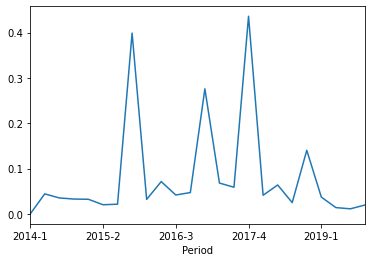

In [39]:
grouped_holdings[grouped_holdings['FilerId']==867].groupby('Period')['TurnOver'].sum().plot()

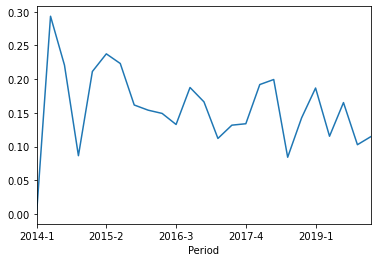

In [40]:
grouped_holdings[grouped_holdings['FilerId']==786].groupby('Period')['TurnOver'].sum().plot()

# now lets get some more features made

In [41]:
grouped_holdings['CumSum'] = grouped_holdings.sort_values('PercentValue', ascending=False).groupby(['FilingId'])['ValueOfShares'].cumsum()

In [42]:
grouped_holdings['num_10_pct'] = grouped_holdings['CumSum']<=(grouped_holdings['TotalValueOfShares']*0.10)
grouped_holdings['num_20_pct'] = grouped_holdings['CumSum']<=(grouped_holdings['TotalValueOfShares']*0.20)
grouped_holdings['num_50_pct'] = grouped_holdings['CumSum']<=(grouped_holdings['TotalValueOfShares']*0.50)

In [43]:
grouped_holdings[grouped_holdings['FilingId']==2200].groupby('FilingId').sum()['num_50_pct']

FilingId
2200   6.00000
Name: num_50_pct, dtype: float64

In [44]:
grouped_holdings[grouped_holdings['FilingId']==877].sort_values('PercentValue', ascending=False)

,Id,FilerId,FilingId,SecurityId,CUSIP,Name,ValueOfShares,NumberOfShares,SharePrice,PercentValue,Period,TotalValueOfShares,TotalNumberOfShares,LastNumberOfShares,LastTotalNumberOfShares,TurnOver,CumSum,num_10_pct,num_20_pct,num_50_pct
26169846,84,867,877,84,949746101,WELLS FARGO & CO. NEW,21040998000,463458123,45.40000,20.07028,2014-1,104836593000,1666390925,0,0,0.00000,21040998000,False,False,True
26169839,24,867,877,24,191216100,COCA-COLA CO.,16524000000,400000000,41.31000,15.76167,2014-1,104836593000,1666390925,0,0,0.00000,37564998000,False,False,True
26169847,90,867,877,90,025816109,American Express Co,13755639000,151610700,90.73000,13.12103,2014-1,104836593000,1666390925,0,0,0.00000,51320637000,False,False,True
26169842,47,867,877,47,459200101,INTERNATIONAL BUSINESS MACHINES,12777641000,68121984,187.57001,12.18815,2014-1,104836593000,1666390925,0,0,0.00000,64098278000,False,False,False
26169844,70,867,877,70,742718109,PROCTER & GAMBLE CO.,4297885000,52793078,81.41001,4.09960,2014-1,104836593000,1666390925,0,0,0.00000,68396163000,False,False,False
26169840,37,867,877,37,30231G102,EXXON MOBIL CORP.,4162320000,41129643,101.20000,3.97029,2014-1,104836593000,1666390925,0,0,0.00000,72558483000,False,False,False
26169851,111,867,877,111,931142103,Wal-Mart Stores Inc,3893875000,49483733,78.69000,3.71423,2014-1,104836593000,1666390925,0,0,0.00000,76452358000,False,False,False
26169850,109,867,877,109,902973304,US Bancorp DE,3204565000,79320901,40.40001,3.05672,2014-1,104836593000,1666390925,0,0,0.00000,79656923000,False,False,False
26169856,326,867,877,326,25490A309,DIRECTV,2521705000,36514700,69.06000,2.40537,2014-1,104836593000,1666390925,0,0,0.00000,82178628000,False,False,False
26169854,311,867,877,311,23918K108,DAVITA HEALTHCARE PARTNERS INC.,2310552000,36461294,63.36999,2.20396,2014-1,104836593000,1666390925,0,0,0.00000,84489180000,False,False,False


# Create finale data frame

In [45]:
grouped_holdings.head()

,Id,FilerId,FilingId,SecurityId,CUSIP,Name,ValueOfShares,NumberOfShares,SharePrice,PercentValue,Period,TotalValueOfShares,TotalNumberOfShares,LastNumberOfShares,LastTotalNumberOfShares,TurnOver,CumSum,num_10_pct,num_20_pct,num_50_pct
0,1,1,1,1,H0023R105,ACE LTD.,24122000,233000,103.52790,1.70674,2014-1,1413334000,22884503,0,0,0.00000,467075000,False,False,True
1,2,1,1,2,00817Y108,AETNA INC. NEW,14061000,205000,68.59024,0.99488,2014-1,1413334000,22884503,0,0,0.00000,1000981000,False,False,False
2,3,1,1,3,001204106,AGL RESOURCES INC.,6848000,145000,47.22759,0.48453,2014-1,1413334000,22884503,0,0,0.00000,1387675000,False,False,False
3,4,1,1,4,018490102,"ALLERGAN, INC.",13330000,120000,111.08333,0.94316,2014-1,1413334000,22884503,0,0,0.00000,1055823000,False,False,False
4,5,1,1,5,020002101,ALLSTATE CORP.,19362000,355000,54.54085,1.36995,2014-1,1413334000,22884503,0,0,0.00000,704351000,False,False,True


In [46]:
features = grouped_holdings[['FilerId', 'FilingId', 'Period', 'TurnOver', 'PercentValue', 'num_10_pct', 'num_20_pct', 'num_50_pct']].groupby(['FilerId', 'FilingId', 'Period']).sum().reset_index()

In [47]:
features.to_csv('13f_dtw_features.csv', index=False)

In [48]:
features.head()

,FilerId,FilingId,Period,TurnOver,PercentValue,num_10_pct,num_20_pct,num_50_pct
0,1,1,2014-1,0.00000,100.00000,2.00000,7.00000,25.00000
1,1,3776,2014-2,0.22115,100.00000,2.00000,6.00000,24.00000
2,1,7584,2014-3,0.16240,100.00000,2.00000,7.00000,25.00000
3,1,11425,2014-4,0.01735,100.00000,2.00000,6.00000,25.00000
4,1,15237,2015-1,0.15425,100.00000,2.00000,7.00000,24.00000


In [49]:
features[features['FilerId']==867]

,FilerId,FilingId,Period,TurnOver,PercentValue,num_10_pct,num_20_pct,num_50_pct
17683,867,877,2014-1,0.00000,100.00000,0.00000,0.00000,3.00000
17684,867,4655,2014-2,0.04420,100.00000,0.00000,0.00000,3.00000
17685,867,8465,2014-3,0.03524,100.00000,0.00000,0.00000,2.00000
17686,867,12324,2014-4,0.03280,100.00000,0.00000,0.00000,2.00000
17687,867,16129,2015-1,0.03227,100.00000,0.00000,0.00000,2.00000
17688,867,20265,2015-2,0.02024,100.00000,0.00000,0.00000,2.00000
17689,867,24345,2015-3,0.02146,100.00000,0.00000,0.00000,2.00000
17690,867,28505,2015-4,0.39893,100.00000,0.00000,1.00000,3.00000
17691,867,32697,2016-1,0.03200,100.00000,0.00000,1.00000,2.00000
17692,867,36906,2016-2,0.07132,100.00000,0.00000,1.00000,2.00000


In [50]:
features[features['FilerId']==443]

,FilerId,FilingId,Period,TurnOver,PercentValue,num_10_pct,num_20_pct,num_50_pct
9216,443,453,2014-1,0.00000,100.00000,0.00000,0.00000,3.00000
9217,443,4274,2014-2,0.11977,100.00000,0.00000,0.00000,3.00000
9218,443,8082,2014-3,0.44887,100.00000,0.00000,1.00000,3.00000
9219,443,11857,2014-4,0.42330,100.00000,0.00000,1.00000,4.00000
9220,443,15710,2015-1,0.70741,100.00000,0.00000,1.00000,4.00000
9221,443,19867,2015-2,0.88410,100.00000,0.00000,1.00000,4.00000
9222,443,23952,2015-3,0.19198,100.00000,0.00000,1.00000,3.00000
9223,443,28084,2015-4,0.19977,100.00000,0.00000,1.00000,3.00000
9224,443,32229,2016-1,0.02860,100.00000,0.00000,1.00000,3.00000
9225,443,36507,2016-2,0.08950,100.00000,0.00000,1.00000,4.00000


Additional ad-hoc research

In [89]:
filer_adhoc = grouped_holdings[['FilerId', 'FilingId', 'Period', 'TurnOver', 'ValueOfShares']].groupby(['FilerId', 'FilingId', 'Period']).sum().reset_index()
filer_adhoc = filer_adhoc.merge(filer_df[['Id','ManagerName', 'CIK']], left_on='FilerId', right_on='Id')[['ManagerName', 'CIK', 'FilerId', 'FilingId', 'Period', 'TurnOver', 'ValueOfShares']]

In [92]:
filer_adhoc[
    (filer_adhoc['Period'] == '2020-1') &
    (filer_adhoc['ValueOfShares']>100000000) &
    (filer_adhoc['ValueOfShares']<200000000)
].sort_values('ValueOfShares').to_csv('filers_100-200M.csv', index=False)